# Assignment 3.2

# Sequence classification model

In [0]:
# Preparing environment

# Install all general packages
!pip install numpy scipy scikit-learn matplotlib pandas pillow graphviz scikit-image

# Graphviz system level
!apt-get install -y graphviz

# Keras 
!pip install keras

In [2]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM, Lambda
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


##Import files we need

In [3]:
from google.colab import files   #upload  labeled/unlabeled1/2 data
uploaded = files.upload()

Saving example1_labelled.tsv to example1_labelled.tsv
Saving example2_labelled.tsv to example2_labelled.tsv
Saving example2_unlabelled.tsv to example2_unlabelled.tsv


In [138]:
pwd #working directory

'/content'

## 1. Preprocess data

#### Tasks:

* Create word vocabulary index (use 10.000 most frequent words)
* Preprocess training and validation set for model input. Use vocabulary index as lookup dictionary to transform raw text into integer sequences. You may use code from Practical 5.

Here we preprocess the data of labeled/unlabeled files. Note that we imported the imdb file from keras, so no preprocessing for that was needed

In [0]:
#Imports
import os
import sys
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
import re
import nltk
from __future__ import print_function
import os
from keras import backend as K



In [0]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pyplot as plt



In [0]:
DATA_PATH = '/content'
EMBEDDING_PATH = 'embedding'
MODEL_PATH = 'model'

train_data = pd.read_csv(os.path.join(DATA_PATH,"example1_labelled.tsv"), header=0, delimiter="\t")     
valid_data = pd.read_csv(os.path.join(DATA_PATH,"example2_unlabelled.tsv"), header=0, delimiter="\t")

In [0]:
# function to clean raw text data

def striphtml(html):
    p = re.compile(r'<.*?>')
    return p.sub('', html)

def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)


In [0]:
# this  will create a cleaned version of labeled 1 file (training)

train_docs = []
train_labels = []
for word, label in zip(train_data.review, train_data.label):    #we clean the labele1 data set (label and review)
    
    doc = clean(striphtml(word))
    doc = doc.lower() 
    train_docs.append(doc)
    train_labels.append(label)

In [76]:
train_data[:3]   #Print the data

,label,review
0,camera,"My husband bought this camera about 3 months ago and we continue to love it...wow, what an impro..."
1,laptop,I got this notebook several months ago and I've had a great experience with it. I've had zero pr...
2,mobilephone,I have this phone for about 10 months. The calls are clear in many places where I can't get my ...


In [0]:
# FUNCTION to tokenize documents into array list of words

def tokenizeWords(text):
    
    tokens = re.sub(r"[^a-z0-9]+", " ", text.lower()).split()
    return [str(strtokens) for strtokens in tokens]

# FUNCTION to create word-level vocabulary index

def indexingVocabulary(array_of_words):

    wordIndex = list(array_of_words)
    
    # we will later pad our sequence into fixed length, so
    # we will use '0' as the integer index of pad 
    wordIndex.insert(0,'<pad>')
    
    # index for word token '<start>' as a starting sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<start>')
    
    # index for word token '<end>' as an ending sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<end>')
    
    # index for word token '<unk>' or unknown words (out of vocabulary words) 
    wordIndex.append('<unk>')
    
    vocab=dict([(i,wordIndex[i]) for i in range(len(wordIndex))])
    
    return vocab

In [0]:
# tokenize text from training set

train_str_tokens = []
all_tokens = []
for i, text in enumerate(train_docs):
    
    # this will create our training corpus
    train_str_tokens.append(tokenizeWords(text))
    
    # this will be our merged array to create vocabulary index
    all_tokens.extend(tokenizeWords(text))

In [0]:
# use nltk to count word frequency and use 10.000 most frequent words to generate vocabulary index

tf = nltk.FreqDist(all_tokens)
common_words = tf.most_common(10000)
arr_common = np.array(common_words)
words = arr_common[:,0]

# create vocabulary index

# word- index pairs
words_indices = indexingVocabulary(words)

# index - word pairs
indices_words = dict((v,k) for (k,v) in words_indices.items())

In [80]:
indices_words

{'10': 167,
 '2': 149,
 '200': 198,
 '2100uz': 92,
 '3': 69,
 '<end>': 213,
 '<pad>': 0,
 '<start>': 212,
 '<unk>': 214,
 'a': 4,
 'about': 16,
 'absolutely': 154,
 'added': 159,
 'admittedly': 85,
 'aging': 89,
 'ago': 21,
 'all': 135,
 'am': 152,
 'an': 37,
 'and': 3,
 'any': 157,
 'anywhere': 98,
 'are': 169,
 'as': 31,
 'at': 83,
 'authorized': 192,
 'basic': 164,
 'battery': 118,
 'be': 59,
 'before': 209,
 'best': 210,
 'booting': 131,
 'bought': 35,
 'but': 39,
 'by': 141,
 'c': 91,
 'called': 190,
 'calls': 168,
 'camera': 36,
 'can': 174,
 'canon': 77,
 'casio': 24,
 'change': 126,
 'changing': 142,
 'charge': 200,
 'clear': 170,
 'computer': 33,
 'concrete': 180,
 'continue': 70,
 'contract': 202,
 'could': 58,
 'couple': 205,
 'course': 93,
 'cradle': 115,
 'days': 206,
 'deluxe': 150,
 'didn': 112,
 'digital': 78,
 'dried': 204,
 'driveway': 181,
 'dropped': 62,
 'easy': 81,
 'elph': 79,
 'especially': 165,
 'even': 26,
 'ever': 211,
 'everywhere': 99,
 'experience': 123,
 

In [0]:
vocab = []
imdbindex = imdb.get_word_index()

for key, word in indices_words.items():
  imdbindex.get(word)
  vocab.append(key)
  

# imdbindex.get("and")

In [0]:
# integer format of training input 
train_int_input = []
for i, text in enumerate(train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    train_int_input.append(int_tokens)

In [0]:
#Labeled 1 data set-------------------
amazon_reviews = []
for review in train_data.review:    
    review_indices = []   
    for word in review:
      index = imdb.get_word_index().get(word)
      if index == None:
        index = 0
      review_indices.append(index)  
    amazon_reviews.append(review_indices)

In [0]:
#Keep the first 500 words
amazon_reviews[0] = amazon_reviews[0][:500]   # We have 3 sets of sentences (reviews)
amazon_reviews[1] = amazon_reviews[1][:500]
amazon_reviews[2] = amazon_reviews[2][:500]

#Preprocessing for unlabbeled data set

In [0]:
# this  will create a cleaned version of validation set (example 2 unlabelled)
# we also need to extract labels from attribute 'id'

valid_docs =[]
valid_labels = []
i=0
for word in valid_data.review:    
    
    doc = clean(striphtml(word))
    doc = doc.lower() 
    valid_docs.append(doc)

In [0]:
# FUNCTION to tokenize documents into array list of words

def tokenizeWords(text):
    
    tokens = re.sub(r"[^a-z0-9]+", " ", text.lower()).split()
    return [str(strtokens) for strtokens in tokens]

# FUNCTION to create word-level vocabulary index

def indexingVocabulary(array_of_words):

    wordIndex = list(array_of_words)
    
    # we will later pad our sequence into fixed length, so
    # we will use '0' as the integer index of pad 
    wordIndex.insert(0,'<pad>')
    
    # index for word token '<start>' as a starting sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<start>')
    
    # index for word token '<end>' as an ending sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<end>')
    
    # index for word token '<unk>' or unknown words (out of vocabulary words) 
    wordIndex.append('<unk>')
    
    vocab=dict([(i,wordIndex[i]) for i in range(len(wordIndex))])
    
    return vocab

In [0]:
valid_str_tokens = []
all_tokens = []
for i, text in enumerate(valid_docs):
    
    # this will create our training corpus
    valid_str_tokens.append(tokenizeWords(text))
    
    # this will be our merged array to create vocabulary index
    all_tokens.extend(tokenizeWords(text))

In [0]:
# integer format of test validation input 
valid_int_input = []
for i, text in enumerate(valid_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    valid_int_input.append(int_tokens)

In [0]:
# use nltk to count word frequency and use 10.000 most frequent words to generate vocabulary index

tf = nltk.FreqDist(all_tokens)
common_words = tf.most_common(10000)
arr_common = np.array(common_words)
words = arr_common[:,0]

# create vocabulary index

# word- index pairs
words_indices = indexingVocabulary(words)

# index - word pairs
indices_words = dict((v,k) for (k,v) in words_indices.items())

In [0]:
#Unlabeled 1 data set
amazon_reviews_valid = []
for review in valid_data.review:    
    review_indices = []   
    for word in review:
      index = imdb.get_word_index().get(word)
      if index == None:
        index = 0
      review_indices.append(index)  
    amazon_reviews_valid.append(review_indices)

In [0]:
amazon_reviews_valid[0] = amazon_reviews_valid[0][:500]
amazon_reviews_valid[1] = amazon_reviews_valid[1][:500]
amazon_reviews_valid[2] = amazon_reviews_valid[2][:500]
amazon_reviews_valid[3] = amazon_reviews_valid[3][:500]
amazon_reviews_valid[4] = amazon_reviews_valid[4][:500]
amazon_reviews_valid[5] = amazon_reviews_valid[5][:500]
amazon_reviews_valid[6] = amazon_reviews_valid[6][:500]

In [92]:
train_data.review[0]

"My husband bought this camera about 3 months ago and we continue to love it...wow, what an improvement over our old Canon Digital Elph. The Casio is SO easy to use: I've never even looked at the manual. Admittedly, I still have a soft spot for my (aging) Oly C-2100UZ but of course it is not pocketable like this Casio. This little workhorse gets taken anywhere and everywhere and gets a lot of use!The Casio has a HUGE LCD and it feels very sturdy. It's incredibly responsive and just feels good! I'm happy with the picture quality (quite good for a subcompact) and I didn't realize how much I would like the cradle for recharging the camera. We bought an extra battery, and haven't even needed to use it yet!"

In [93]:
amazon_reviews[2]  

[0,
 0,
 2020,
 3,
 1961,
 960,
 0,
 827,
 2020,
 10,
 587,
 0,
 1654,
 2020,
 1601,
 3360,
 960,
 0,
 1206,
 1601,
 1476,
 0,
 3,
 500,
 1601,
 1203,
 827,
 0,
 297,
 2238,
 0,
 1980,
 1601,
 3360,
 827,
 2020,
 587,
 0,
 0,
 0,
 0,
 2020,
 960,
 0,
 1145,
 3,
 2011,
 2011,
 587,
 0,
 3,
 1476,
 960,
 0,
 1145,
 2011,
 960,
 3,
 1476,
 0,
 10,
 3360,
 0,
 1980,
 3,
 3360,
 5132,
 0,
 1654,
 2011,
 3,
 1145,
 960,
 587,
 0,
 1989,
 2020,
 960,
 1476,
 960,
 0,
 0,
 0,
 1145,
 3,
 3360,
 755,
 827,
 0,
 1328,
 960,
 827,
 0,
 1980,
 5132,
 0,
 1601,
 827,
 2020,
 960,
 1476,
 0,
 587,
 960,
 1476,
 1961,
 10,
 1145,
 960,
 0,
 827,
 1601,
 0,
 1989,
 1601,
 1476,
 2292,
 0,
 0,
 0,
 0,
 2020,
 3,
 1961,
 960,
 0,
 1092,
 1476,
 1601,
 1654,
 1654,
 960,
 1092,
 0,
 10,
 827,
 0,
 3360,
 1203,
 1980,
 960,
 1476,
 1601,
 1203,
 587,
 0,
 827,
 10,
 1980,
 960,
 587,
 0,
 1601,
 3360,
 0,
 1601,
 1203,
 1476,
 0,
 1145,
 1601,
 3360,
 1145,
 1476,
 960,
 827,
 960,
 0,
 1092,
 1476,
 10,


#Preprocessing done

## 2. Sequence classification model

#### Tasks: 

* Create a RNN model to classify sequence of words on a binary classification task
* Compare four (4) different gate memory units
* Plot model performance (loss and accuracy) of these 4 models
* Present the performance (loss and accuarcy) of these 4 models in a comparison table

In [0]:
#Since the data set is quite large we tried with a realtive small number of epochs. 3 seemed to give the best results with relatively good time

num_epochs = 3
batch_size = 64
embedding_vector_length = 32

In [0]:
top_words = 10000
(X1_train, y1_train), (X1_test, y1_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500 #number of words in review
X1_train = sequence.pad_sequences(X1_train, maxlen=max_review_length)
X1_test = sequence.pad_sequences(X1_test, maxlen=max_review_length)
# create the model
embedding_vector_length = 32


X_train = X1_train[:10000]
y_train = y1_train[:10000]

X_test = X1_test[:5000]
y_test = y1_test[:5000]



#Here we train the 4 models to find the one with the best accuracy

### Model 1 : LSTM

In [0]:
#LSTM--------------------------------
# create the model
LSTM_model = Sequential()
LSTM_model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
LSTM_model.add(LSTM(64))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(128,activation='relu',name='neural_codes'))
LSTM_model.add(Dense(1, activation='sigmoid'))



### Model 2: GRU

In [0]:
# MODEL-2: GRU------------
gru_model = Sequential()
gru_model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation='sigmoid'))



### Model 3 : Bidirectional LSTM

In [0]:
# MODEL-3: Bidirectional LSTM---------------

BI_LSTM_model = Sequential()
BI_LSTM_model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
BI_LSTM_model.add(Bidirectional(LSTM(64)))
BI_LSTM_model.add(Dropout(0.3))
BI_LSTM_model.add(Dense(1, activation='sigmoid'))



### Model 4 : Bidirectional GRU

In [0]:
# MODEL-4: Bidirectional GRU-----------------
bi_gru_model = Sequential()
bi_gru_model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
bi_gru_model.add(Bidirectional(LSTM(64)))
bi_gru_model.add(Dropout(0.2))
bi_gru_model.add(Dense(1, activation='sigmoid'))




### Compile models

In [120]:
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(LSTM_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
neural_codes (Dense)         (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 353,281
Trainable params: 353,281
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 338,689
Trainable params: 338,689
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
BI_LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(BI_LSTM_model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 369,793
Trainable params: 369,793
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
bi_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_gru_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           320000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               49664     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 369,793
Trainable params: 369,793
Non-trainable params: 0
_________________________________________________________________
None


In [98]:
X_train

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,   20,   18, 2166],
       [   0,    0,    0, ...,  154,  172,  154],
       [   0,    0,    0, ...,   10,   10, 3288]], dtype=int32)

### Train models

In [121]:
#LSTM training

historylstm = LSTM_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

LSTM_scores = LSTM_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (LSTM_scores[1]*100))

Train on 10000 samples, validate on 5000 samples
Epoch 1/3
10000/10000 [==============================] - 85s 9ms/step - loss: 0.5388 - acc: 0.7177 - val_loss: 0.4014 - val_acc: 0.8180
Epoch 2/3
10000/10000 [==============================] - 85s 9ms/step - loss: 0.2590 - acc: 0.9005 - val_loss: 0.3655 - val_acc: 0.8360
Epoch 3/3
 5056/10000 [==============>...............] - ETA: 38s - loss: 0.1548 - acc: 0.9488

10000/10000 [==============================] - 85s 8ms/step - loss: 0.1652 - acc: 0.9425 - val_loss: 0.3801 - val_acc: 0.8532
Accuracy: 85.32%


In [122]:
 LSTM_scores = LSTM_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (LSTM_scores[1]*100))

Accuracy: 85.32%


In [44]:
# GRU TRAINING
historygru = gru_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

gru_scores = gru_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (gru_scores[1]*100))


Train on 10000 samples, validate on 5000 samples
Epoch 1/3
10000/10000 [==============================] - 75s 8ms/step - loss: 0.6131 - acc: 0.6457 - val_loss: 0.5788 - val_acc: 0.7898
Epoch 2/3
10000/10000 [==============================] - 74s 7ms/step - loss: 0.3119 - acc: 0.8680 - val_loss: 0.3651 - val_acc: 0.8412
Epoch 3/3
 5056/10000 [==============>...............] - ETA: 33s - loss: 0.1588 - acc: 0.9438

10000/10000 [==============================] - 74s 7ms/step - loss: 0.1777 - acc: 0.9351 - val_loss: 0.4080 - val_acc: 0.8470
Accuracy: 84.70%


In [52]:
history_BI_LSTM = BI_LSTM_model.fit(X_train, y_train, epochs=3, batch_size=64,validation_data=(X_test, y_test))

BI_LSTM_scores = BI_LSTM_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (BI_LSTM_scores[1]*100))
#dorpout 0.2 -> 83.9

Train on 10000 samples, validate on 5000 samples
Epoch 1/3
10000/10000 [==============================] - 150s 15ms/step - loss: 0.5615 - acc: 0.6961 - val_loss: 0.3779 - val_acc: 0.8386
Epoch 2/3
10000/10000 [==============================] - 148s 15ms/step - loss: 0.2963 - acc: 0.8863 - val_loss: 0.3791 - val_acc: 0.8446
Epoch 3/3
 4928/10000 [=============>................] - ETA: 1:08 - loss: 0.2082 - acc: 0.9257

10000/10000 [==============================] - 148s 15ms/step - loss: 0.2094 - acc: 0.9253 - val_loss: 0.3922 - val_acc: 0.8468
Accuracy: 84.68%


In [64]:
history_gru_model = bi_gru_model.fit(X_train, y_train, epochs=3, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
bi_gru_scores = bi_gru_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (bi_gru_scores[1]*100))


Train on 10000 samples, validate on 5000 samples
Epoch 1/3
10000/10000 [==============================] - 150s 15ms/step - loss: 0.5836 - acc: 0.6900 - val_loss: 0.4217 - val_acc: 0.8184
Epoch 2/3
10000/10000 [==============================] - 148s 15ms/step - loss: 0.3486 - acc: 0.8593 - val_loss: 0.3634 - val_acc: 0.8444
Epoch 3/3
 4928/10000 [=============>................] - ETA: 1:07 - loss: 0.2249 - acc: 0.9188

10000/10000 [==============================] - 148s 15ms/step - loss: 0.2230 - acc: 0.9187 - val_loss: 0.3785 - val_acc: 0.8440
Accuracy: 84.40%


As we can see the "best" model which provides us with the best accuracy is LSTM with an accuracy of 86.1%. Specifically we get:

LSTM: 85.30%%
GRU: 84.7%
Bidirectional LSTM: 84.6%
Bidirectional GRU: 84.4%

Having a bigger number for the epochs did not seem to help with accuracy. 3 Seemed to be the optimal choice

### Save models and weight parameters

In [0]:
# Save model
LSTM_model.save('lstm_model.h5')
# Save trained weight parameters
LSTM_model.save_weights('weights_lstm_model.hdf5')

In [0]:
# Save model
gru_model.save('gru_model.h5')
# Save trained weight parameters
gru_model.save_weights('weights_gru_model.hdf5')

In [0]:
# Save model
BI_LSTM_model.save('bilstm_model.h5')
# Save trained weight parameters
BI_LSTM_model.save_weights('weights_bilstm_model.hdf5')

In [0]:
# Save model
bi_gru_model.save('bigru_model.h5')
# Save trained weight parameters
bi_gru_model.save_weights('weights_bigru_model.hdf5')

#### Plot model performance (loss, accuracy)

#Plot for LSTM

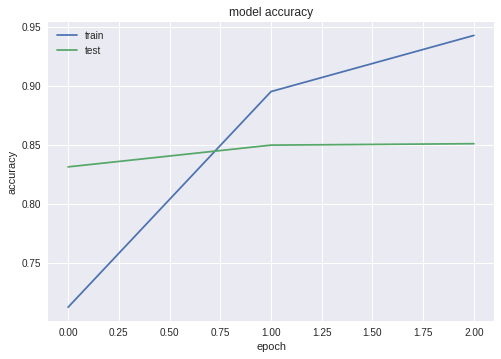

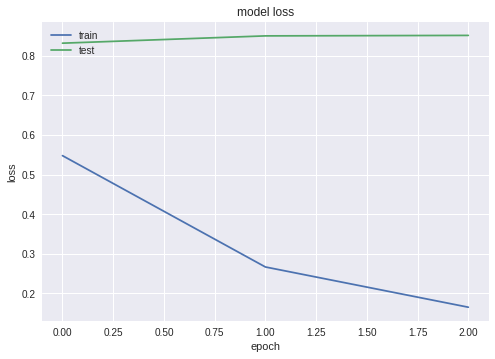

In [69]:
plt.plot(historylstm.history['acc'])
plt.plot(historylstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historylstm.history['loss'])
plt.plot(historylstm.history['val_acc']) #c = 'r', linestyle = "--")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot for GRU

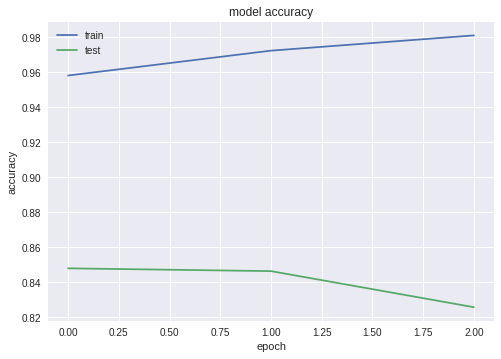

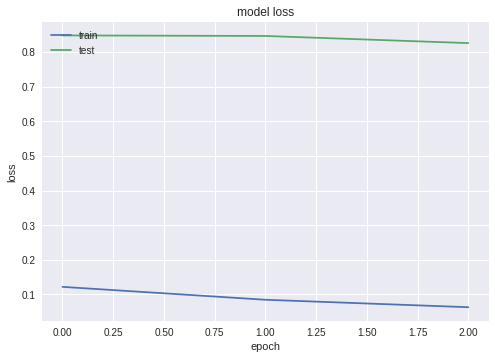

In [100]:

plt.plot(historygru.history['acc'])
plt.plot(historygru.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historygru.history['loss'])
plt.plot(historygru.history['val_acc']) #c = 'r', linestyle = "--")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot for BI_LSTM

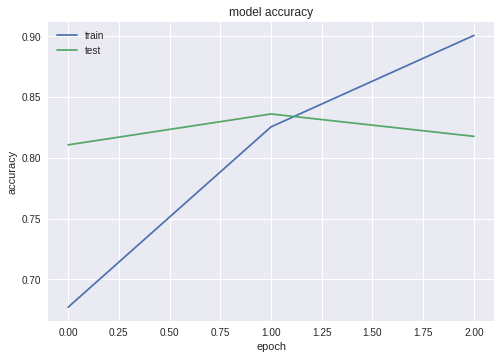

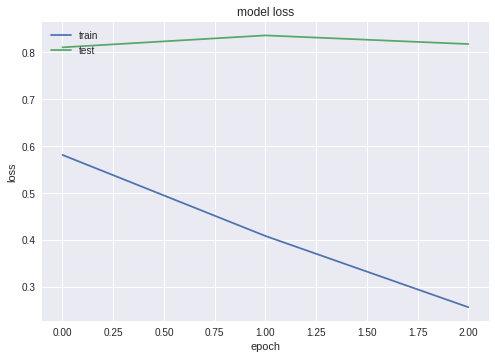

In [139]:
plt.plot(history_BI_LSTM.history['acc'])
plt.plot(history_BI_LSTM.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_BI_LSTM.history['loss'])
plt.plot(history_BI_LSTM.history['val_acc']) #c = 'r', linestyle = "--")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot for BI_GRU

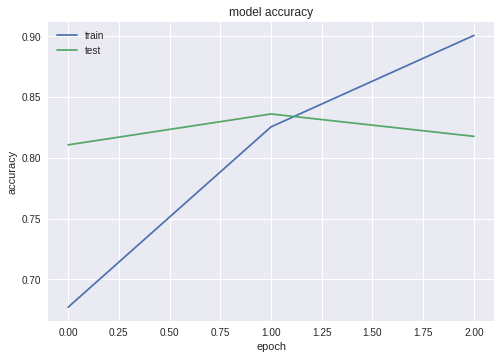

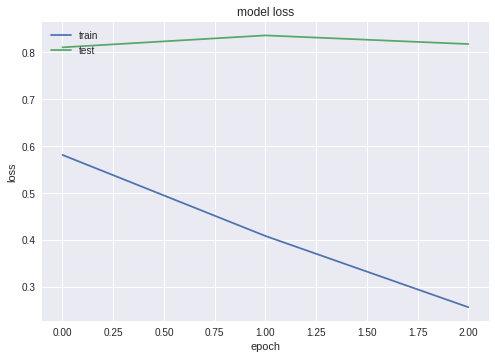

In [140]:
plt.plot(history_BI_LSTM.history['acc'])
plt.plot(history_BI_LSTM.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_BI_LSTM.history['loss'])
plt.plot(history_BI_LSTM.history['val_acc']) #c = 'r', linestyle = "--")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Present table comparison of model performance

#### Answer:

=== write your answer here ===

(can also be presented as figure of table)

In [159]:
# Presenting a table with accuracies

df = pd.DataFrame({'$LSTM':[85.3], '$GRU': [84.7],  '$BI_LSTM':[84.6], '$BI_GRU': [84.4]})
df.columns = ['BI_GRU', 'BI_LSTM','GRU', 'LSTM']
df

,BI_GRU,BI_LSTM,GRU,LSTM
0,84.4,84.6,84.7,85.3


### 3. Feature extraction

#### Tasks: 

* Choose one model with the best performance and use the model to produce ”neural codes” (document embedding) of raw text (5000 instances of unseen validation set) from RNN layer.
*  Use tSNE to reduce the dimension of extracted text features (encoded version of 5000 documents) into two (2) dimensions and visualize it towards their sentiment labels.


#### Produce Neural codes of text reviews

In [0]:
# Make neural codes for IMDB data set
neural_codes_output = K.function([LSTM_model.layers[0].input],       #encoder model
                                 [LSTM_model.get_layer("neural_codes").output])
 # embedings for IMDB
IMDB_embeddings = neural_codes_output([ X1_test])[0] 


In [0]:

# # define sub model to retrieve "neural codes" (document embedding) from recurrent layer
# # generate "neural codes" (document embedding) from the model



# # Make neural codes for IMDB data set
encoder_model = K.function([LSTM_model.layers[0].input],       #encoder model
                                 [LSTM_model.get_layer("neural_codes").output])
 # embedings for IMDB
doc_embedding = neural_codes_output([ X1_test])[0] 


#### tSNE visualization

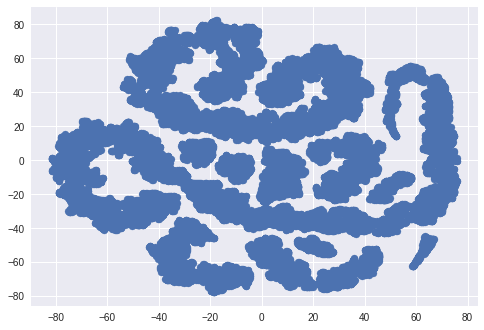

In [125]:
# use tSNE to plot document embedding on its sentiment label
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_model = tsne.fit_transform(IMDB_embeddings)   #TSNE for imdb data set
tsne_model.shape

plt.scatter(tsne_model[:,0],tsne_model[:,1])
plt.show()

### 4. One shot learning on multi-class classification

#### Tasks: 

* Use the RNN model that has been trained on binary classification task to extract features from different data set (Amazon product reviews)
* Define and implement an approach to assign labels on unlabelled set of reviews, by using the concept of "one shot learning"
* Compute accuracy, given ground truth labels
* Discuss the results 

#EMBEDDINGS FOR LABELED FILE

In [0]:
neural_codes_output = K.function([LSTM_model.layers[0].input],       #encoder model
                                 [LSTM_model.get_layer("neural_codes").output])

#PREPROCESS amazon, get the integers 
tests_embeddings = neural_codes_output([ amazon_reviews])[0]  


In [138]:
len(tests_embeddings[2])

128

In [0]:
tests_embeddings = neural_codes_output([ amazon_reviews])[0]  #try with diff brackets  #doc embeding #for unlabeled

In [0]:
#make nearets neigbours with the 3 embedings
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors = 1, metric = "l2").fit( tests_embeddings )  #create the nearest neighbours "space"

#Embedings for validation file

In [0]:
valid_embeddings = neural_codes_output([ amazon_reviews_valid])[0]  #doc embeding for unlabeled

In [0]:
amazon_class = []
for embedding in valid_embeddings:
  distances, indices = nn.kneighbors([ embedding ])
  nearest_index = indices[0][0] # Get the nearest neighbor
  distance = distances[0][0]
  amazon_class.append(train_data.label[nearest_index])

In [0]:
#distances, indices = nn.kneighbors([ tests_embeddings ])

In [144]:
amazon_class[:7]

['camera', 'camera', 'laptop', 'camera', 'laptop', 'camera', 'camera']

Explain how the approach works.


#### Answer:

First we imported the IMDB data set from Keras. We trained our 4 models with that data to determine the best ones, with the smallent ammount of loss. After we determined our best model we get 2 different embedings, 1 for the labeled amazon dataset and one for the untrained amazon data set. After that we create a "nearest neighbour space" for the labeled file embedings. Now that we have our "space" we translate our unlabeled file embedings on that space and we find the closest labels for each word, by measuring the smallest distance. After that we have 7 predictions for the unlabeled amazon reviews.

In [0]:
test_data = pd.read_csv(os.path.join(DATA_PATH,"example2_labelled.tsv"), header=0, delimiter="\t")

In [0]:
test_set = []

for item in test_data.label:
  test_set.append(item)

In [147]:
print(amazon_class)
print(test_set)

['camera', 'camera', 'laptop', 'camera', 'laptop', 'camera', 'camera']
['camera', 'mobilephone', 'laptop', 'laptop', 'mobilephone', 'camera', 'camera']


In [148]:
count = 0;

for x,y in zip(test_set, amazon_class):
  if(x == y):
    count = count+1

    
accuracy = (count/len(amazon_class))*100
print(accuracy)

57.14285714285714


Discuss the result. Why it works -- or why it does not work.

#### Answer:

As we can see the accuracy is relatively good (57%),  if we keep in mind that we used the sentiment embeddings for predicting the amazon product classes. We computed the accuracy ourselves since we have the provided data set with the correct predictions. As we can see also above 4/7 predictions were right. The point here is to understand that using sentiment values we have computed we could actually predict many classes correct , with an unorthodox way, since sentiment analysis is not frequently used for problems like this.